In [ ]:
import numpy as np 
import pandas as pd 
import pyreadr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from tensorflow.keras.models import load_model
import numpy as np
import json
from umap.umap_ import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import save_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# homemade functions and scripts
import model_ae
import utils

c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Autoencoder 

In this project, we aim to analyse the brain low-grade gliomas and glioblastomas tumours from TCGA. In this part, we will use an unsupervised approach, autoencoders, to reconstruct the dataset and analyse: 
- the quality of the output reconstruction of the dataset 
- the most important features and characteristics of the latent space, indicative of the data structure
- the genes most contributing to the model

## Loading data and autoencoder model 

The bulk RNA-Seq TCGA data was previously preprocessed. Three data files are available: 
- the expression data `../data/merged_expression.csv` containing the gene expression data
- the sample metadata `../data/merged_samples.rds` containing the available clinical metadata
- the gene annotations `../data/merged_genes.csv` containing gene information, which we will use to get the correspondance between Ensembl id and gene names for clear visualisations. 

The autoencoder model was previously tuned on the expression data. Based on the best parameters identified, the final model was retrained and we saved: the final model and parameters, the latent projections of `X_train`/`X_test` and the output reconstructions of `X_train`/`X_test`. 

We will load the model, latent projections, reconstructions as well as the data files. We will perform the data preparation (scaling and train-test split) again and load the `X_train` and `X_test` with the same parameters as during the model training as to ensure an identical train-test split. 


In [ ]:
# load model
model = load_model("final_autoencoder.keras")

# load latent embeddings
Z_train = np.load("final_Z_train.npy")
Z_test  = np.load("final_Z_test.npy")

# load reconstructions
X_train_rec = np.load("final_X_train_rec.npy")
X_test_rec  = np.load("final_X_test_rec.npy")

# load parameters
with open("final_params.json") as f:
    params = json.load(f)

In [ ]:
# loading expression matrix
X = pd.read_csv("../data/merged_expression.csv", index_col=0)
X.head()

,ENSG00000276168.1,ENSG00000263740.2,ENSG00000133048.13,ENSG00000265735.2,ENSG00000202058.1,ENSG00000198695.2,ENSG00000252010.1,ENSG00000198763.3,ENSG00000129824.16,ENSG00000200312.1,...,ENSG00000204851.7,ENSG00000154734.16,ENSG00000164949.8,ENSG00000132465.12,ENSG00000242950.7,ENSG00000263968.2,ENSG00000135218.19,ENSG00000100867.15,ENSG00000253485.2,ENSG00000004848.8
TCGA-HT-7468-01A-11R-2027-07,8.604286,5.563223,7.809334,5.075322,6.060727,15.949436,5.294349,17.023827,13.257817,5.075322,...,9.637190,9.430882,7.854691,5.727468,6.920168,5.912624,7.931828,8.237980,6.638368,6.675950
TCGA-DU-7015-01A-11R-2027-07,8.453606,5.546896,8.858111,5.546896,5.591451,16.920221,5.286967,17.667525,6.386164,5.075322,...,9.944071,8.778698,9.661123,9.055161,5.983611,5.705796,6.206395,8.166694,6.804484,6.071344
TCGA-HT-7601-01A-11R-2090-07,9.694192,5.479652,11.204155,5.596186,5.541698,16.028277,5.075322,17.127280,5.645290,5.075322,...,9.469871,9.993919,10.731195,6.319223,5.996416,5.479652,8.368708,7.778204,7.353568,6.812570
TCGA-DU-A6S7-01A-21R-A32Q-07,8.322266,5.563448,7.701043,5.075322,6.147194,17.479665,5.075322,18.113888,5.671750,5.075322,...,10.426091,9.112219,10.194877,5.563448,6.147194,6.221050,6.704041,9.823169,11.942656,6.818724
TCGA-IK-7675-01A-11R-2090-07,8.279067,5.604416,8.531655,5.450490,5.755886,16.774909,5.450490,17.546353,9.459408,5.075322,...,9.429267,8.303989,10.715684,6.354291,6.546661,5.721549,6.722158,7.784506,6.843659,8.389566


Our input expression matrix shows samples x genes and contains the expression of the 2000 most highly variable genes, as selected during feature selection. It is ready for feeding into our entoencoder. 

In [ ]:
# setting label y as sample name
y = X.index
y

Index(['TCGA-HT-7468-01A-11R-2027-07', 'TCGA-DU-7015-01A-11R-2027-07',
       'TCGA-HT-7601-01A-11R-2090-07', 'TCGA-DU-A6S7-01A-21R-A32Q-07',
       'TCGA-IK-7675-01A-11R-2090-07', 'TCGA-E1-A7YE-01A-11R-A34F-07',
       'TCGA-HT-8107-01A-13R-2404-07', 'TCGA-HT-7467-01A-11R-2027-07',
       'TCGA-DU-8164-01A-11R-2256-07', 'TCGA-TQ-A7RF-01A-11R-A33Z-07',
       ...
       'TCGA-06-2563-01A-01R-A96S-41', 'TCGA-06-0158-01A-01R-A96R-41',
       'TCGA-06-0158-01A-01R-1849-01', 'TCGA-27-1837-01A-01R-1850-01',
       'TCGA-12-3644-01A-01R-A96T-41', 'TCGA-12-0618-01A-01R-A96S-41',
       'TCGA-76-4929-01A-01R-1850-01', 'TCGA-06-6698-01A-11R-A96S-41',
       'TCGA-06-0879-01A-01R-A96S-41', 'TCGA-06-0155-01B-01R-A96R-41'],
      dtype='object', length=925)

In [ ]:
# data preparation (scaling and train-test split)
X_train, X_test, y_train, y_test = model_ae.load_data() 
print(X_train.shape)
print(X_test.shape)

(740, 2000)
(185, 2000)


In [ ]:
# storing X_train and X_test as dataframes to retrieve row and column names
X_train_df = pd.DataFrame(X_train, 
                        columns=X.columns,
                        index=y_train)
X_train_df.head()

X_test_df = pd.DataFrame(X_test, 
                        columns=X.columns,
                        index=y_test)
X_test_df.head()

,ENSG00000276168.1,ENSG00000263740.2,ENSG00000133048.13,ENSG00000265735.2,ENSG00000202058.1,ENSG00000198695.2,ENSG00000252010.1,ENSG00000198763.3,ENSG00000129824.16,ENSG00000200312.1,...,ENSG00000204851.7,ENSG00000154734.16,ENSG00000164949.8,ENSG00000132465.12,ENSG00000242950.7,ENSG00000263968.2,ENSG00000135218.19,ENSG00000100867.15,ENSG00000253485.2,ENSG00000004848.8
TCGA-12-3644-01A-01R-A96T-41,2.292896,2.262483,0.307937,2.176809,2.446045,-2.086074,2.725061,-2.046884,-1.397372,2.259117,...,-2.272953,0.951969,0.195749,-0.560007,1.823525,2.729038,0.497824,-0.231536,-0.123874,-0.958357
TCGA-06-0678-11A-32R-A36H-07,-0.039824,-0.498517,0.013251,-0.504801,-0.538465,0.733796,-0.512486,0.699130,0.551252,-0.540502,...,2.366489,2.001783,0.287986,-0.411557,-0.440228,-0.445031,-0.929762,1.400754,0.487086,2.213850
TCGA-HT-7882-01A-11R-2403-07,-0.407931,-0.594093,1.363330,-0.520389,-0.543965,0.274193,-0.481897,0.364993,0.681124,-0.540502,...,-1.491204,2.808186,2.153366,2.749754,-0.722980,-0.621987,3.160648,-0.523543,-0.245500,-1.021957
TCGA-S9-A6TS-01A-12R-A33Z-07,-0.619204,-0.660709,-0.314166,-0.525581,-0.487894,0.675114,-0.556630,0.376971,-1.216888,-0.540502,...,0.892490,-0.877625,-0.267015,-0.563757,-0.783661,-0.598219,-0.501969,-0.465724,-0.592815,0.133027
TCGA-19-4065-01A-01R-2005-01,-0.465509,-0.512048,1.523577,-0.517119,-0.420418,0.412163,-0.478514,0.231296,1.093418,-0.376643,...,-1.389699,0.073877,0.461428,1.813194,-0.849350,-0.620688,0.494213,-1.150250,-1.138375,0.912947


Finally, we load the gene annotations and sample metadata to retrieve gene names from ensembl ids as well as the clinical data we need for results analysis and interpretation. 

In [6]:
# gene annotations
genes = pd.read_csv("../data/merged_genes.csv")
genes.head()

# creating gene map to retrieve gene names from emsembl ids
gene_map = dict(zip(genes["gene_id"], genes["gene_name"])) 

In [7]:
# sample metadata
meta = pyreadr.read_r("../data/merged_samples.rds")
meta.keys() #checking contents of the OrderedDict object 
samples = meta[None]
samples.head()

# creating map to retrieve tumour type (GBM vs LGG) for each sample in the test set
tumor_type_map = samples.set_index("sample_id")["tumor_type"]
tumor_for_test = X_test.index.map(tumor_type_map)
tumor_for_test = tumor_for_test.fillna("NA") 
tumor_map = tumor_for_test.astype("category")
colors_tumor = tumor_map.codes

# creating map to retrieve tumour grade (G1, G2, G3, G4) for each sample in the test set
tumor_grade_map = samples.set_index("sample_id")["tumor_grade"]
tumor_for_test = X_test.index.map(tumor_grade_map)
tumor_for_test = tumor_for_test.fillna("NA") 
grade_map = tumor_for_test.astype("category")
colors_grade = grade_map.codes

## Comparing the reconstruction of the output to the input data

Firstly, we are interested in understanding how well the autoencoder was able to reconstruct the data. This will enable us to know how much of the data structure the autoencoder was able to identify, which will give us an indication regarding the reliability of our results. 

We start by quantifying reconstruction quality using the mean-squared error (MSE), which compared the average squared deviation between each input and reconstructed observation. Global MSE summarizes overall fit; per-feature MSE shows which variables are harder to reconstruct; per-class MSE reveals whether some species are intrinsically less well captured by the same 2-dimensional bottleneck. Similar train and test MSEs indicate that the model has learned general patterns rather than memorizing the training set.

In [ ]:
# global mse 
mse_train = np.mean((X_train - X_train_rec)**2)
mse_test  = np.mean((X_test  - X_test_rec )**2)

# per feature mse on test data
mse_per_feature = np.mean((X_test - X_test_rec)**2, axis=0)

# per sample mse on test data 
mse_per_sample = ((X_test_rec - X_test)**2).mean(axis=1)

# per type mse on test data (gbm vs lgg)
mse_by_tumor = (
    mse_per_sample.groupby(tumor_map)
    .mean()
    .to_dict()
)

# per grade mse on test data (G2 vs G3 vs G4)
mse_by_tumor = (
    mse_per_sample.groupby(grade_map)
    .mean()
    .to_dict()
)

print("Global MSE (train):", mse_train)
print("Global MSE (test):", mse_test)
print("Per-type (LGG vs GBM) MSE (test):", mse_by_tumor)
print("Per-grade (G2 vs G3 vs G4) MSE (test):", mse_by_tumor)

Global MSE (train): 0.3330955100091445
Global MSE (test): 0.3648183580337844
Per-class MSE (test): {'GBM': 0.3937416700567384, 'LGG': 0.34553615001848165}


C:\Users\themi\AppData\Local\Temp\ipykernel_16312\3711175992.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mse_per_sample.groupby(tumor_map)


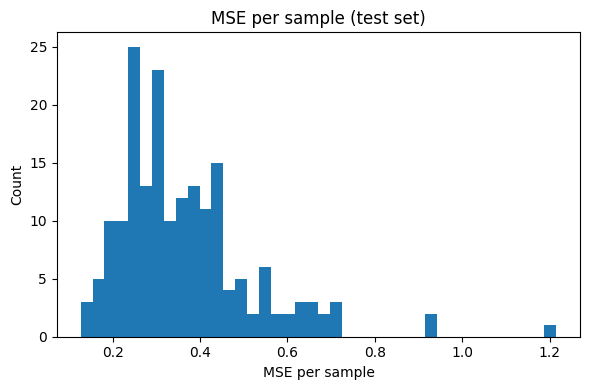

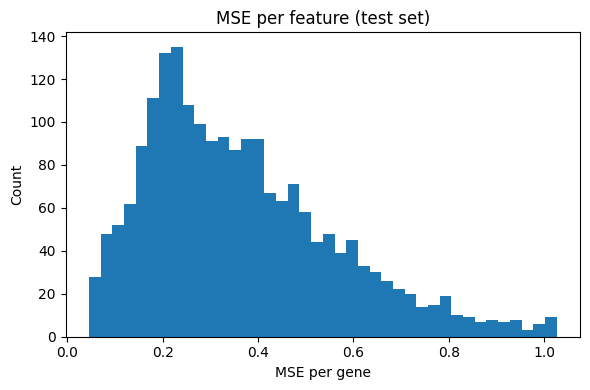

In [13]:
# plotting the mse distribution per sample and per gene 

plt.figure(figsize=(6,4))
plt.hist(mse_per_sample, bins=40)
plt.xlabel("MSE per sample")
plt.ylabel("Count")
plt.title("MSE per sample (test set)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(mse_per_feature, bins=40)
plt.xlabel("MSE per gene")
plt.ylabel("Count")
plt.title("MSE per feature (test set)")
plt.tight_layout()
plt.show()


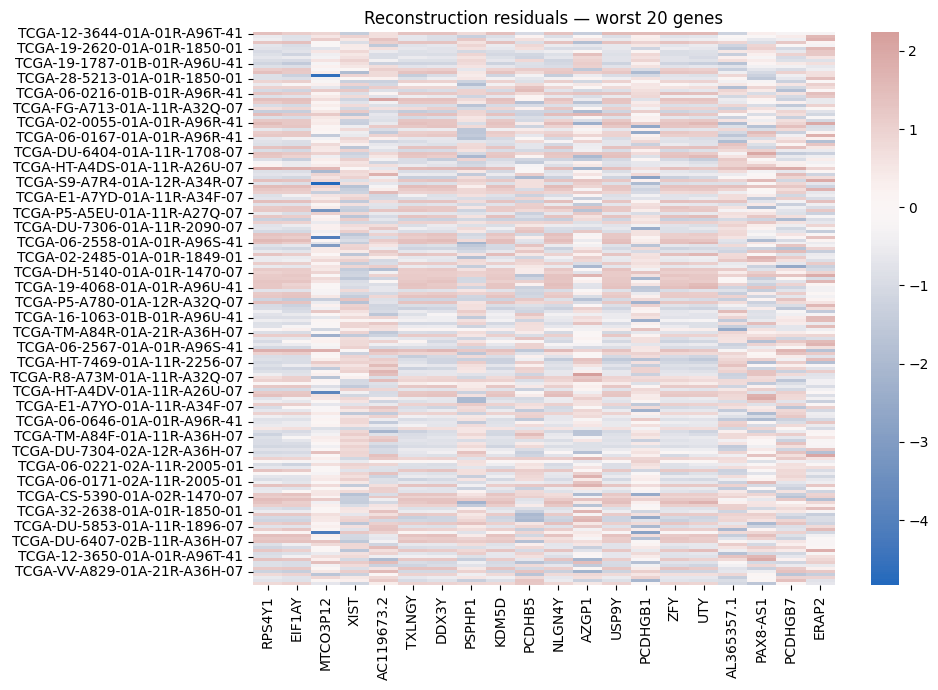

In [14]:
# heatmap of the reconstructed vs input gene counts for the worst genes
worst_genes = mse_per_feature.sort_values(ascending=False).head(20).index
residuals = X_test_rec[worst_genes] - X_test[worst_genes]

gene_map = dict(zip(genes["gene_id"], genes["gene_name"]))
residuals.columns = [gene_map.get(g, g) for g in residuals.columns]

plt.figure(figsize=(10,7))
sns.heatmap(residuals, cmap="vlag", center=0)
plt.title("Reconstruction residuals — worst 20 genes")
plt.tight_layout()
plt.show()


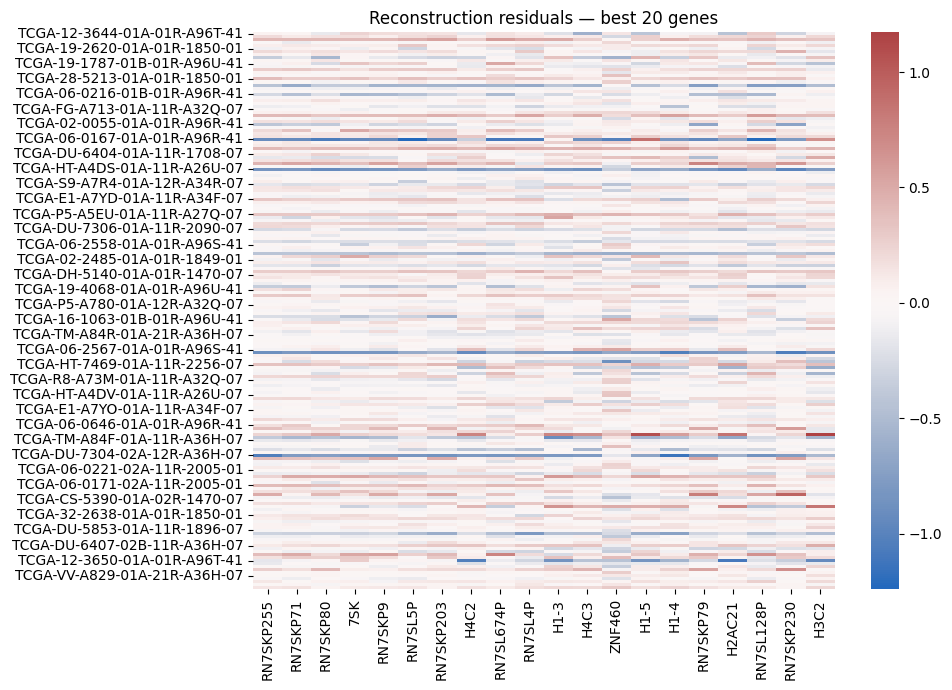

In [15]:
# heatmap of the reconstructed vs input gene counts for the best genes
best_genes = mse_per_feature.sort_values(ascending=True).head(20).index
residuals = X_test_rec[best_genes] - X_test[best_genes]

gene_map = dict(zip(genes["gene_id"], genes["gene_name"]))
residuals.columns = [gene_map.get(g, g) for g in residuals.columns]

plt.figure(figsize=(10,7))
sns.heatmap(residuals, cmap="vlag", center=0)
plt.title("Reconstruction residuals — best 20 genes")
plt.tight_layout()
plt.show()

## Separate encoder and latent projection

Once trained, we extract the encoder to map samples into the 10-dimensional latent space. Plotting the test set in this space reveals how the network organizes data without using labels during training. Clusters typically emerge because the model learns a compact geometric arrangement that best supports accurate reconstruction of the standardized inputs.

In [16]:
encoder = models.Model(inputs=ae.input, 
                outputs=ae.get_layer("encoder").output, 
                name="encoder_model") #extract encoder 

In [17]:
Z_train = encoder.predict(X_train) #encoder train data
Z_test = encoder.predict(X_test) #encoder test data

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


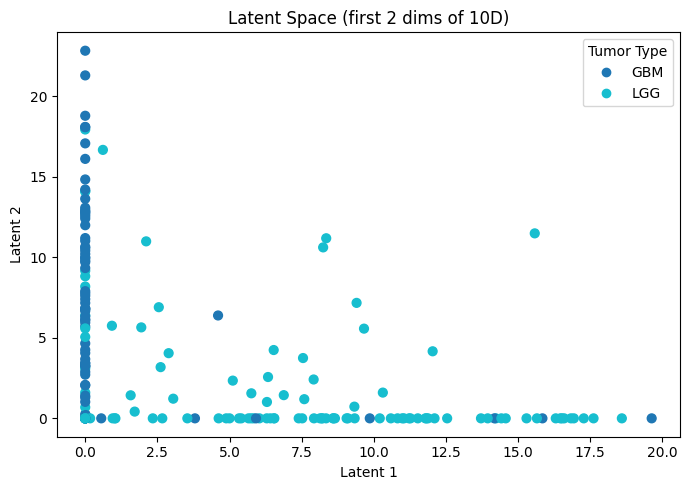

In [18]:
plt.figure(figsize=(7, 5))
if Z_test.shape[1] == 1:
    plt.scatter(
        Z_test[:, 0],
        np.zeros_like(Z_test[:, 0]),
        c=colors_tumor, cmap="tab10", s=40
    )
    plt.xlabel("Latent 1")
    plt.title("Latent Space (1D)")

elif Z_test.shape[1] == 2:
    plt.scatter(
        Z_test[:, 0], Z_test[:, 1],
        c=colors_tumor, cmap="tab10", s=40
    )
    plt.xlabel("Latent 1")
    plt.ylabel("Latent 2")
    plt.title("Latent Space (2D)")

else:
    plt.scatter(
        Z_test[:, 0], Z_test[:, 1],
        c=colors_tumor, cmap="tab10", s=40
    )
    plt.xlabel("Latent 1")
    plt.ylabel("Latent 2")
    plt.title(f"Latent Space (first 2 dims of {Z_test.shape[1]}D)")

# legend for tumor types 
cmap = plt.cm.tab10
norm = matplotlib.colors.Normalize(vmin=colors_tumor.min(), vmax=colors_tumor.max())

handles = [
    plt.Line2D([], [], marker="o", linestyle="",
               color=cmap(norm(i)), label=tt)
    for i, tt in enumerate(tumor_map.categories)
]

plt.legend(handles=handles, title="Tumor Type", loc="upper right")
plt.tight_layout()
plt.show()


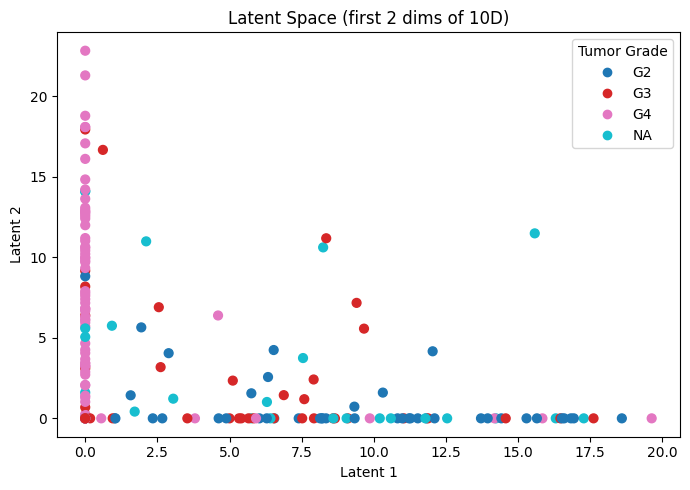

In [19]:
plt.figure(figsize=(7, 5))
if Z_test.shape[1] == 1:
    plt.scatter(
        Z_test[:, 0],
        np.zeros_like(Z_test[:, 0]),
        c=colors_grade, cmap="tab10", s=40
    )
    plt.xlabel("Latent 1")
    plt.title("Latent Space (1D)")

elif Z_test.shape[1] == 2:
    plt.scatter(
        Z_test[:, 0], Z_test[:, 1],
        c=colors_grade, cmap="tab10", s=40
    )
    plt.xlabel("Latent 1")
    plt.ylabel("Latent 2")
    plt.title("Latent Space (2D)")

else:
    plt.scatter(
        Z_test[:, 0], Z_test[:, 1],
        c=colors_grade, cmap="tab10", s=40
    )
    plt.xlabel("Latent 1")
    plt.ylabel("Latent 2")
    plt.title(f"Latent Space (first 2 dims of {Z_test.shape[1]}D)")

# legend for tumour grades 
cmap = plt.cm.tab10
norm = matplotlib.colors.Normalize(vmin=colors_grade.min(), vmax=colors_grade.max())

handles = [
    plt.Line2D([], [], marker="o", linestyle="",
               color=cmap(norm(i)), label=tt)
    for i, tt in enumerate(grade_map.categories)
]

plt.legend(handles=handles, title="Tumor Grade", loc="upper right")
plt.tight_layout()
plt.show()


When visualising the first 2 dimensions of the latent space representation of the test data, we can see that the encoder could well capture the tumour type information: GBM vs LGG. While LGG is mostly separable on the first dimension, GBM is mostly separable on the second dimension, suggesting that these tumour types are treated by two separate neurons in the encoder. The demarcation is less clear for tumour grades, where, while all G4 tumours are GBM, LGG are splitted into G3 and G2, not clearly separable on either dimension. 

To get a broader overview of the latent projection of the test data, we will learn a UMAP representation on the projected data and check whether tumour grade has an impact overall. 

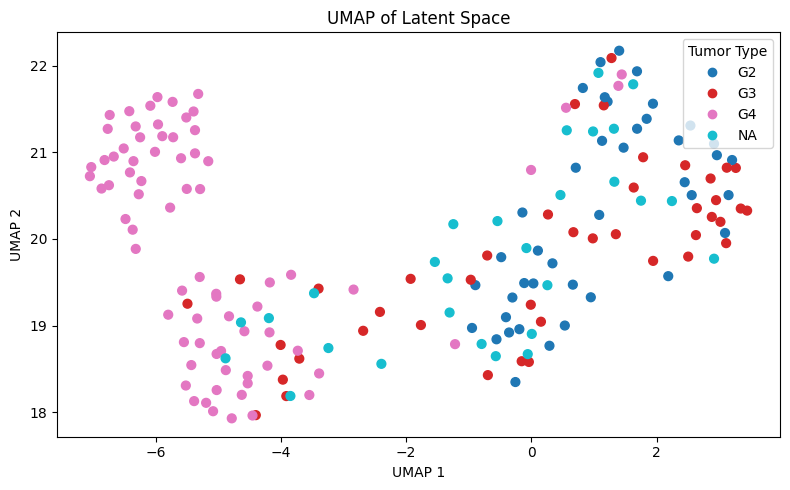

In [20]:
Z_umap = UMAP(n_neighbors=20, min_dist=0.3).fit_transform(Z_test)

# Build a shared colormap + normalization
cmap = plt.cm.tab10
norm = matplotlib.colors.Normalize(vmin=colors_grade.min(), vmax=colors_grade.max())

# Plot using the SAME mapping
plt.figure(figsize=(8,5))
sc = plt.scatter(
    Z_umap[:, 0], Z_umap[:, 1],
    c=colors_grade, cmap=cmap, norm=norm, s=40
)

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP of Latent Space")

# Legend using exact category→code mapping
handles = [
    plt.Line2D([], [], marker="o", linestyle="",
               color=cmap(norm(code)), label=label)
    for code, label in enumerate(grade_map.categories)
]

plt.legend(handles=handles, title="Tumor Type", loc="upper right")
plt.tight_layout()
plt.show()


The latent space overall does not seem to capture the tumour grade diversity clearly. Moving on from this basic first autoencoder, we will complexify the model structure, tune its hyperparameters... to try to build a more robust representation and get further insight into our data structure. 

A simple way to test usefulness of the latent representation is to train a lightweight classifier on it. A k-nearest neighbors (kNN) model on Z provides an immediate sanity check: if accuracy remains competitive with kNN on the original standardized features, the 2-dimensional code preserves class-relevant structure while being more compact.

In [22]:
#train knn on latent embeddings 
label_map = samples.set_index("sample_id")["tumor_type"]
y_train_label = y_train.map(label_map)
y_test_label  = y_test.map(label_map)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Z_train, y_train_label)

#predict test set
knn_pred = knn.predict(Z_test)

accuracy = accuracy_score(y_test_label, knn_pred)
print(f"KNN accuracy on latent space: {accuracy:.3f}")

KNN accuracy on latent space: 0.914


We get a good accuracy of 0.914, suggesting that the latent representation of the autoencoder model is preserving the class-relevant structure. 

## Investigating marker contributions to the model 

We are now interested in understanding which genes seem to contribute most to the model, i.e. to the reconstruction of the input through the autoencoder. Indeed, this could help us identify genes important for the data structure, e.g. differentiation of the cancer classes. 

To that aim, we will use two different methods: 
- the calculation of gradient-based feature importance, i.e. calculate the impact of perturbating one gene on the model's latent space (a high gradient indicates that the gene strongly influences the encoding)
- the calculation of the correlation between each gene and each latent dimension (a gene highly correlated with the first dimension is suggested to strongly influence the encoding)

We will then investigate the biological function and relevance of these identified genes regarding to cancer to uncover some meaningful insights. 


In [23]:
# calculating gradient-based feature importance 
x = tf.convert_to_tensor(X_test, dtype=tf.float32)
x = tf.Variable(x)

with tf.GradientTape() as tape:
    z = encoder(x) # latent outputs

grads = tape.gradient(z, x).numpy()  # shape: (samples, genes)
gene_importance = np.mean(np.abs(grads), axis=0)

# visualising the top 20 genes 
top_indices = np.argsort(-gene_importance)[:20]
top20_df = pd.DataFrame({
    "gene_name": X_test.columns[top_indices].map(lambda x: gene_map.get(x, x)),
    "feature_importance": gene_importance[top_indices]
})
top20_df


,gene_name,feature_importance
0,ADCY1,0.368597
1,CCL3,0.325953
2,DDX25,0.307562
3,RAB3B,0.298436
4,GRIN3A,0.286133
5,ANGPTL2,0.284034
6,NELL2,0.274635
7,MEG3,0.273006
8,HOXA10,0.270404
9,ASCL1,0.267948


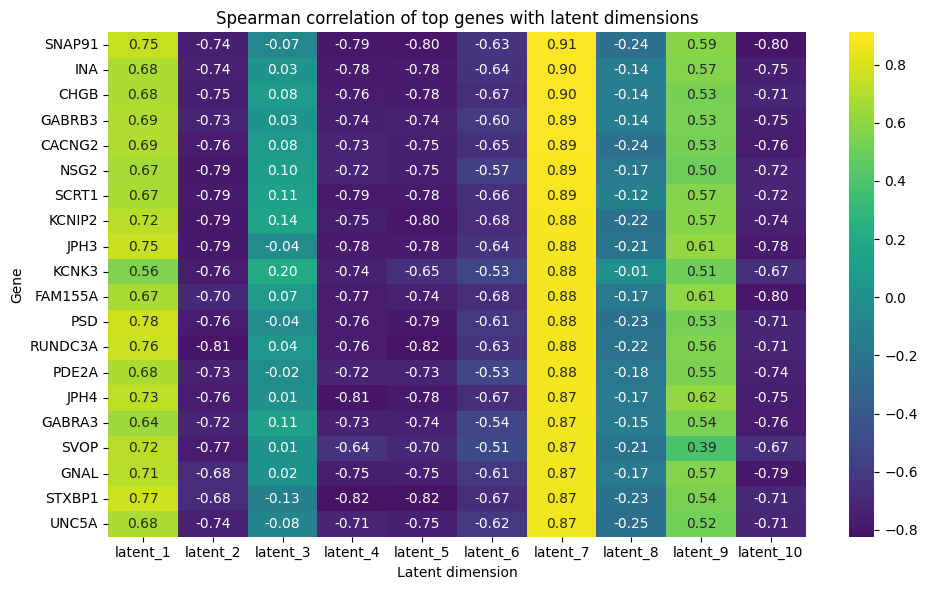

In [24]:
# calculating correlation between each gene and latent dimension
corr = np.array([
    [st.spearmanr(Z_test[:,k], X_test.iloc[:,g])[0]
     for g in range(X_test.shape[1])]
    for k in range(Z_test.shape[1])]
)

corr_df = pd.DataFrame(
    corr.T,  # genes as rows, latent dimensions as columns
    index=X_test.columns,  # gene names
    columns=[f"latent_{i+1}" for i in range(Z_test.shape[1])]
)

#selecting top 20 genes
gene_importance = corr_df.abs().max(axis=1)
top_genes = gene_importance.sort_values(ascending=False).head(20).index
corr_top = corr_df.loc[top_genes]
corr_top.index = [gene_map.get(i,i) for i in corr_top.index]


plt.figure(figsize=(10,6))
sns.heatmap(
    corr_top, 
    cmap="viridis",      
    center=0,   
    annot=True,
    fmt=".2f"
)
plt.title("Spearman correlation of top genes with latent dimensions")
plt.xlabel("Latent dimension")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()



## PCA comparison 

PCA provides a linear reference. By projecting the standardized data into its first two principal components, we can compare what a linear method preserves versus what the non-linear autoencoder emphasizes. Differences between the two views indicate where non-linear structure helps organize the data for reconstruction.

In [25]:
# scaling whole data 
dat_scaled = StandardScaler().fit_transform(dat)
X = pd.DataFrame(dat_scaled, 
                columns=dat.columns,
                index=dat.index)
X.head()

pca = PCA(n_components=2)
Z = pca.fit_transform(X)

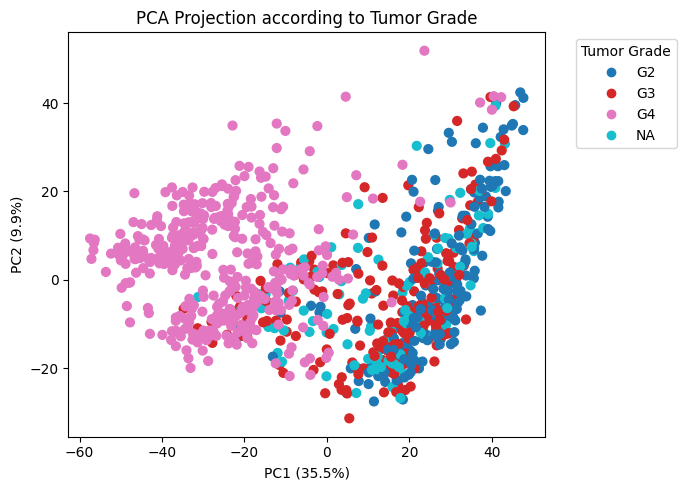

In [26]:
# --- Map y_test -> tumor_grade ---
map_tumor = samples.set_index("sample_id")["tumor_grade"]
tumor_for_test = pd.Series(y).map(map_tumor).fillna("NA")

# Convert to categorical codes
tumor_cat = tumor_for_test.astype("category")
colors = tumor_cat.cat.codes     # numeric codes used for cmap

# PCA variance
explained_var = pca.explained_variance_ratio_ * 100

# ---- Scatter ----
plt.figure(figsize=(7, 5))
scatter = plt.scatter(
    Z[:, 0], Z[:, 1],
    c=colors,
    cmap="tab10",
    s=40,
)

plt.xlabel(f"PC1 ({explained_var[0]:.1f}%)")
plt.ylabel(f"PC2 ({explained_var[1]:.1f}%)")
plt.title("PCA Projection according to Tumor Grade")

# ---- Legend using same colors ----
cmap = plt.cm.tab10
norm = plt.Normalize(vmin=colors.min(), vmax=colors.max())

handles = [
    plt.Line2D([], [], marker="o", linestyle="",
               color=cmap(norm(i)), label=tt)
    for i, tt in enumerate(tumor_cat.cat.categories)
]

plt.legend(handles=handles, title="Tumor Grade",
           bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


We can see that the PCA seemed to separate the data slightly less clearly than the autoencoder, with a less explicit separation of the grade 4 tumours. This suggests that there might be a non-linear axe of variance in the data, that was not captured by PCA. 

## Export model and embeddings 

In order to keep track of the model trained and optimisation, we will save the model to be able to reproduce the embedding later if needed. 

In [29]:
#save models 
ae.save("first_autoencoder/ae_glioms.keras") # full autoencoder
encoder.save("first_autoencoder/encoder_gliomas.keras") # encoder only

In [31]:
#save embeddings and reconstructions
pd.DataFrame(Z_train, columns=[f"Z{i+1}" for i in range(Z_train.shape[1])])\
  .assign(sample_id=y_train)\
  .to_csv("first_autoencoder/glioma_latent_train.csv", index=False)

pd.DataFrame(Z_test, columns=[f"Z{i+1}" for i in range(Z_test.shape[1])])\
  .assign(sample_id=y_test)\
  .to_csv("first_autoencoder/iris_latent_test.csv", index=False)

pd.DataFrame(X_test_rec, columns=[f"Feature{i+1}" for i in range(X_test_rec.shape[1])])\
  .to_csv("first_autoencoder/glioma_recon_test.csv", index=False)